# Normal Neural Network: MNIST example

In this example, we train a simple network. 

# Import Modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn
seaborn.set(font_scale=2)
seaborn.set_style("white")

import sys
sys.path.append("../")

import numpy as np
from scipy.spatial import HalfspaceIntersection
import warnings

pritn = print

from convex_adversarial import robust_loss

In [2]:
## 어떤 python에서 돌아가는지
## 환경, 버전
print(sys.executable)

/home/tako/anaconda3/envs/lsy/bin/python


In [3]:
print(sys.path)

['', '/home/tako/anaconda3/envs/lsy/lib/python36.zip', '/home/tako/anaconda3/envs/lsy/lib/python3.6', '/home/tako/anaconda3/envs/lsy/lib/python3.6/lib-dynload', '/home/tako/anaconda3/envs/lsy/lib/python3.6/site-packages', '/home/tako/anaconda3/envs/lsy/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg', '/home/tako/anaconda3/envs/lsy/lib/python3.6/site-packages/IPython/extensions', '/home/tako/.ipython', '../']


In [4]:
## warning 없애기
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [5]:
### GPU 연결 확인
print(torch.cuda.current_device()) #연결된 gpu idx
print(torch.cuda.device(0))
print(torch.cuda.device_count()) #연결된 gpu갯수
print(torch.cuda.get_device_name(0)) #연결된 gpu이름

0
2
TITAN Xp


In [6]:
torch.cuda.set_device(1)

# Set Parameters

In [7]:
batch_size = 50

#  Load data

In [8]:
mnist_trainset = datasets.MNIST(root='./data/', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data/', train=False, download=True, transform=transforms.ToTensor())
data_loader  = torch.utils.data.DataLoader(dataset=mnist_trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)
test_data_loader  = torch.utils.data.DataLoader(dataset=mnist_testset,
                                          batch_size=50,
                                          shuffle=True,
                                          num_workers=1)

In [9]:
n_samples = mnist_trainset.train_data.shape[0]

In [10]:
mnist_trainset.train_data.shape, mnist_testset.test_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [11]:
mnist_trainset.train_labels.shape, mnist_testset.test_labels.shape

(torch.Size([60000]), torch.Size([10000]))

max and min 255 0


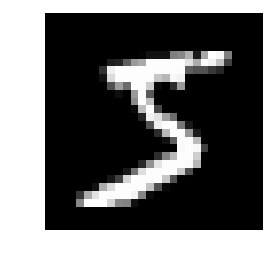

In [12]:
train_ex = mnist_trainset.train_data[0].numpy()
print('max and min', train_ex.max(), train_ex.min())
plt.imshow(train_ex, 'gray')
plt.axis('off')
plt.show()

In [13]:
X_train = mnist_trainset.train_data
y_train = mnist_trainset.train_labels
X_test = mnist_testset.test_data
y_test = mnist_testset.test_labels

In [14]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

## Normal Neural Network

In [15]:
epsilon = 0.1 #0.5

In [16]:
#torch.manual_seed(1)
net = nn.Sequential(
    nn.Conv2d(1,16, 2, stride=(2,2)),
    nn.ReLU(),
    nn.Conv2d(16,32, 2, stride=(2,2)),
    nn.ReLU(),
    Flatten(),
    nn.Linear(7*7*32,100),
    nn.ReLU(),
    nn.Linear(100,10)
)

st = time.time()
opt = optim.Adam(net.parameters(), lr=1e-3)
# for i in range(1000):
#     out = net(Variable(X_train))
#     l = nn.CrossEntropyLoss()(out, Variable(y_train))
#     err = (out.max(1)[1].data != y_train).float().mean()
#     if i % 100 == 0:
#         print('loss: %.6f, err: %.3f'%(l.data[0], err))
#     opt.zero_grad()
#     (l).backward()
#     opt.step()
for i in range(100):
    print('-'*60)
    print('<'*5, i,'th iteration', '>'*5)
    for j, (batch_images, batch_labels) in enumerate(data_loader):
        X = Variable(batch_images.cuda())
        Y = Variable(batch_labels.cuda())        
            
        out = net.cuda()(X)
        l2 = nn.CrossEntropyLoss()(out, Y)
        err = (out.max(1)[1].data != batch_labels.cuda()).float().mean()
        
        if j % (n_samples//(2*batch_size)) == 0:
            print('Plain err: %.5f'%(err))
        opt.zero_grad()
        l2.backward()
        opt.step()
        if j % 10 == 0:
             print('%.2f %%'%(100*j/(n_samples/(batch_size))), end='\r')
    
print('last loss: %.6f'%l2)
print(time.time()-st)

------------------------------------------------------------
<<<<< 0 th iteration >>>>>
Plain err: 0.94000
Plain err: 0.06000
------------------------------------------------------------
<<<<< 1 th iteration >>>>>
Plain err: 0.04000
Plain err: 0.06000
------------------------------------------------------------
<<<<< 2 th iteration >>>>>
Plain err: 0.02000
Plain err: 0.00000
------------------------------------------------------------
<<<<< 3 th iteration >>>>>
Plain err: 0.00000
Plain err: 0.02000
------------------------------------------------------------
<<<<< 4 th iteration >>>>>
Plain err: 0.00000
Plain err: 0.00000
------------------------------------------------------------
<<<<< 5 th iteration >>>>>
Plain err: 0.02000
Plain err: 0.06000
------------------------------------------------------------
<<<<< 6 th iteration >>>>>
Plain err: 0.02000
Plain err: 0.00000
------------------------------------------------------------
<<<<< 7 th iteration >>>>>
Plain err: 0.00000
Plain err: 

Plain err: 0.00000
Plain err: 0.00000
------------------------------------------------------------
<<<<< 65 th iteration >>>>>
Plain err: 0.00000
Plain err: 0.00000
------------------------------------------------------------
<<<<< 66 th iteration >>>>>
Plain err: 0.00000
Plain err: 0.00000
------------------------------------------------------------
<<<<< 67 th iteration >>>>>
Plain err: 0.00000
Plain err: 0.00000
------------------------------------------------------------
<<<<< 68 th iteration >>>>>
Plain err: 0.00000
Plain err: 0.00000
------------------------------------------------------------
<<<<< 69 th iteration >>>>>
Plain err: 0.00000
Plain err: 0.00000
------------------------------------------------------------
<<<<< 70 th iteration >>>>>
Plain err: 0.00000
Plain err: 0.00000
------------------------------------------------------------
<<<<< 71 th iteration >>>>>
Plain err: 0.00000
Plain err: 0.00000
------------------------------------------------------------
<<<<< 72 th 